In [25]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.io
import albumentations as albu
import torch
import numpy as np

from segmentation_models_pytorch import *

In [26]:
import pandas as pd

In [27]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse
           2 : (204, 0, 0),  #Eisenbahn
           3 : (230, 128, 0), #Fußweg
           4 : (255, 0, 0),  #Karawanenweg
           5 : (0, 204, 242), #Saumweg
         }

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d


In [28]:
DATA_DIR = r"C:\Users\cagat\Desktop\yol_ve_tiler\Yol_Multi_Class\Dataset"
#
#DATA_DIR = r"C:\Users\CBS-7\Desktop\Revised_Test"

x_train_dir = os.path.join(DATA_DIR, 'Train', 'Image')
y_train_dir = os.path.join(DATA_DIR, 'Train', 'Mask')

x_valid_dir = os.path.join(DATA_DIR, 'Val', 'Image')
y_valid_dir = os.path.join(DATA_DIR, 'Val', 'Mask')

x_test_dir = os.path.join(DATA_DIR, 'Test', 'Image')
y_test_dir = os.path.join(DATA_DIR, 'Test', 'Mask')

In [29]:
class Dataset(BaseDataset):
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.mask_ids = os.listdir(masks_dir)

        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.mask_ids]
        
        self.class_values = np.arange(0,6,1)
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    @staticmethod
    def _read_img(image_path):
        img = skimage.io.imread(image_path, plugin='tifffile')
        return img

    def __getitem__(self, i):
        
        # read data
        im_id = self.images_fps[i].split('\\')[-1]
        image = self._read_img(self.images_fps[i])
        image = image[:,:,0:3]
        mask =  self._read_img(self.masks_fps[i])
    
        if self.augmentation is not None:
            transformed = self.augmentation(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            
        if self.preprocessing:
            preprocessed  = self.preprocessing(image=image, mask=mask)
            image,mask = preprocessed['image'], preprocessed['mask']

        mask_raw = convert_from_color(mask) 
        masks = [(mask_raw == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1)      
       
        image = image.transpose(2, 0, 1).astype('float32') 
        mask = mask.transpose(2, 0, 1).astype('float32')
        
        image_ = image / image.max()
        
        image = torch.as_tensor(image, dtype=torch.float32).cuda()
        mask = torch.as_tensor(mask, dtype=torch.float32).cuda()        

                       
        return image, mask
        
    def __len__(self):
        return len(self.ids)

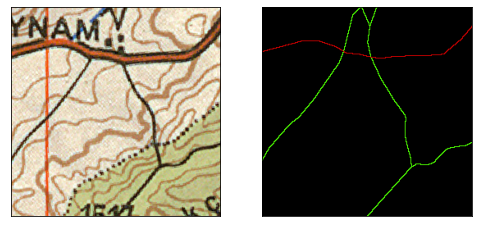

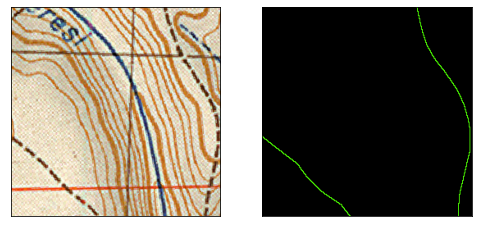

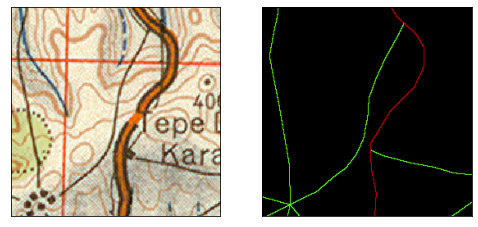

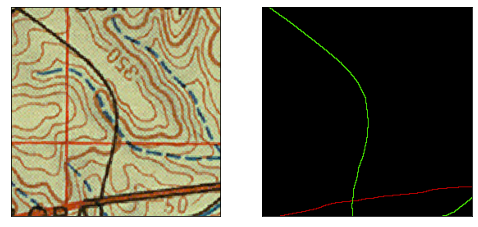

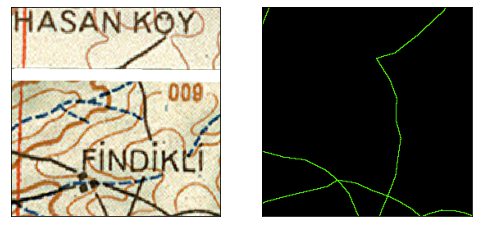

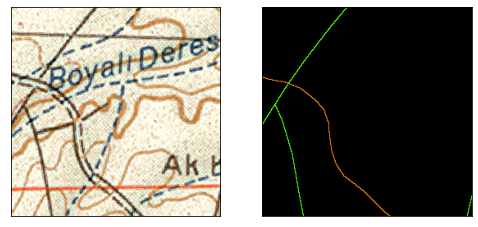

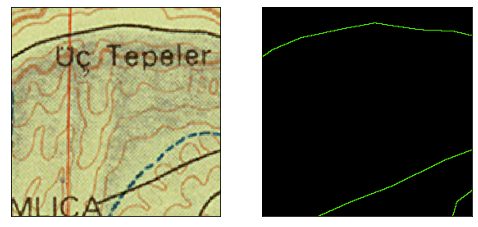

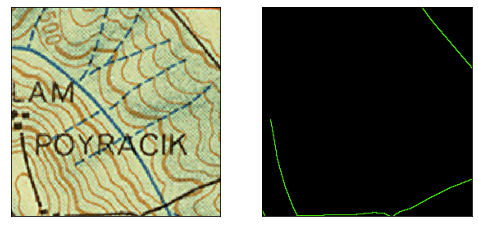

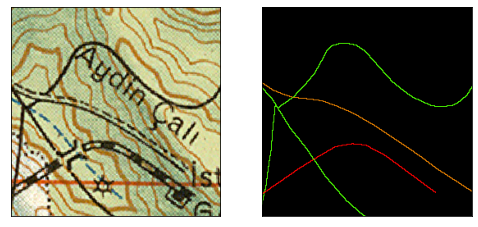

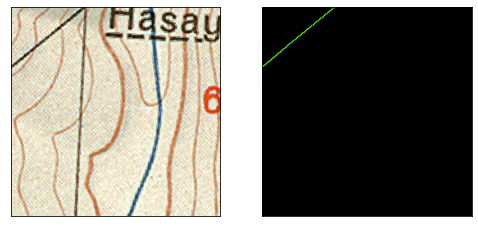

In [30]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        #plt.title(' '.join(name.split('_')).title())
        plt.subplots_adjust(left=0.5, bottom=None, right=0.9, top=None, wspace=None, hspace=None)

        plt.imshow(image)
    plt.show()
    
for i in range(10):
    dataset = Dataset(x_train_dir, y_train_dir)

    image, mask = dataset[np.random.randint(len(dataset))] # get some sample
    image = image.detach().cpu().numpy()
    mask  = mask.detach().cpu().numpy()

    mask0 = np.transpose(mask, (1,2,0))
    
    mask1 = np.argmax(mask0, axis = 2)
    image = np.transpose(image, (1,2,0)).astype('uint8')
    mask = convert_to_color(mask1)

    visualize(
        map_patch = image,
        ground_truth_mask = mask)

In [31]:
def get_training_augmentation():
    train_transform =     train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        #albu.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=256, width=256, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.RandomCrop(height=256, width=256, always_apply=True),
    ]
    return albu.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
    ]
    return albu.Compose(_transform)

In [32]:
ENCODER = 'timm-resnest200e'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = np.arange(0,6,1)
ACTIVATION = 'softmax2d' 
DEVICE = 'cuda'

model = UnetPlusPlus(encoder_name=ENCODER, 
                encoder_weights= ENCODER_WEIGHTS, 
                classes=len(CLASSES), 
                activation=ACTIVATION)

log_path = r"C:\Users\cagat\Desktop\log_path_20"
experiment_log = r"timm-resnest200e"

In [33]:
!pip install ipywidgets

In [10]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation= get_training_augmentation(), 
    preprocessing= None, 
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation= get_validation_augmentation(), 
    preprocessing= None,
)

C:\Users\cagat\AppData\Roaming\Python\Python39\site-packages\albumentations\imgaug\transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
C:\Users\cagat\AppData\Roaming\Python\Python39\site-packages\albumentations\imgaug\transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
C:\Users\cagat\AppData\Roaming\Python\Python39\site-packages\albumentations\augmentations\transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\cagat\AppData\Roaming\Python\Python39\site-packages\albumentations\imgaug\transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Ple

In [11]:
#!pip install pytorch-toolbelt

In [34]:
from sklearn.utils import compute_sample_weight
from pytorch_toolbelt.utils import fs
from torch.utils.data import WeightedRandomSampler

def get_balanced_weights(dataset):
    labels=[]
    for mask in dataset.masks_fps:
      mask = fs.read_image_as_is(mask)
      unique_labels = np.unique(mask)
      labels.append(''.join([str(int(i)) for i in unique_labels]))

    weights = compute_sample_weight('balanced', labels)
    return weights

In [13]:
mul_factor =  5 #increases the total # of ims in a batch
train_sampler = WeightedRandomSampler(get_balanced_weights(train_dataset), len(train_dataset) * mul_factor)
valid_sampler = WeightedRandomSampler(get_balanced_weights(valid_dataset), len(valid_dataset) * mul_factor)

In [14]:
list(train_sampler.weights)

[tensor(4.1275, dtype=torch.float64),
 tensor(4.1275, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(3.0055, dtype=torch.float64),
 tensor(4.1275, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(3.0055, dtype=torch.float64),
 tensor(3.0055, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(4.1275, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(3.0055, dtype=torch.float64),
 tensor(0.1019, dtype=torch.float64),
 tensor(4.1275, dtype=torch.float64),
 tensor(0.10

In [15]:
train_loader = DataLoader(train_dataset, batch_size=8, sampler=train_sampler)
valid_loader = DataLoader(valid_dataset, batch_size=8, sampler=valid_sampler)

In [35]:
loss = utils.losses.DiceLoss(ignore_channels=[0]) 

In [36]:
metrics = [utils.metrics.Fscore(threshold=0.5,ignore_channels=[0]),
    utils.metrics.Precision(threshold=0.5,ignore_channels=[0]), 
    utils.metrics.Recall(threshold=0.5,ignore_channels=[0])]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
#cengo eklemeler

In [37]:
metrics = [utils.metrics.Fscore(threshold=0.5,ignore_channels=[0]),
    utils.metrics.Precision(threshold=0.5,ignore_channels=[0]), 
    utils.metrics.Recall(threshold=0.5,ignore_channels=[0]),
    utils.metrics.IoU(threshold=0.5,ignore_channels=[0])]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [18]:
train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [19]:
max_score = 0 
train_logs_list, valid_logs_list = [], []

for i in range(0, 30):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)

    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, os.path.join(log_path, '.\{}.pth'.format(experiment_log)))
        print('Model saved!')
        
    if i == 6:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|                                                                                  | 0/3096 [00:00<?, ?it/s]

C:\Users\cagat\anaconda3\envs\cagoseg\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train: 100%|█| 3096/3096 [53:43<00:00,  1.04s/it, dice_loss - 0.6176, fscore - 0.4006, precision - 0.3346, recall - 0.5
valid: 100%|█| 885/885 [05:23<00:00,  2.73it/s, dice_loss - 0.5418, fscore - 0.4618, precision - 0.39, recall - 0.5787]
Model saved!

Epoch: 1
train: 100%|█| 3096/3096 [53:51<00:00,  1.04s/it, dice_loss - 0.5162, fscore - 0.4863, precision - 0.4165, recall - 0.5
valid: 100%|█| 885/885 [05:24<00:00,  2.72it/s, dice_loss - 0.5323, fscore - 0.4694, precision - 0.4018, recall - 0.577
Model saved!

Epoch: 2
train: 100%|█| 3096/3096 [53:58<00:00,  1.05s/it, dice_loss - 0.4918, fscore - 0.5097, precision - 0.4393, recall - 0.6
valid: 100%|█| 885/885 [05:24<00:00,  2.72it/s, dice_loss - 0.5164, fscore - 0.4849, precision - 0.4221, recall - 0.581
Model saved!

Epoch: 3
train: 100%|█| 3096/3096 [54:12<00:00,  1.05s/it, dice_loss - 0.4765, fscore - 0.5246, precision - 0.4542, recall - 0.6
valid: 100%|█| 885/885 [05:29<00:00,  2.68it/s, dice_loss - 0.4989, fscore - 0.5017, precis

In [38]:
best_model = torch.load(os.path.join(log_path, '.\{}.pth'.format(experiment_log)))

In [39]:
best_model.cuda()

UnetPlusPlus(
  (encoder): ResNestEncoder(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [40]:
# create test dataset
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
)

test_dataloader = DataLoader(test_dataset)

In [41]:
# evaluate model on test set
test_epoch = utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid:   0%| | 1/708 [00:01<21:57,  1.86s/it, dice_loss - 0.3488, fscore - 0.6495, precision - 0.5632, recall - 0.7672,

C:\Users\cagat\anaconda3\envs\cagoseg\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


valid: 100%|█| 708/708 [01:07<00:00, 10.56it/s, dice_loss - 0.4326, fscore - 0.5668, precision - 0.5125, recall - 0.686


In [42]:
logs

{'dice_loss': 0.43257944386894404,
 'fscore': 0.5667604687885077,
 'precision': 0.5124991291825425,
 'recall': 0.6860772453462285,
 'iou_score': 0.4101327720345125}

In [43]:
logs

{'dice_loss': 0.43257944386894404,
 'fscore': 0.5667604687885077,
 'precision': 0.5124991291825425,
 'recall': 0.6860772453462285,
 'iou_score': 0.4101327720345125}

In [27]:
def visualize_nd_dwn(idx, **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
        #save_dir = os.path.join(r'C:\Users\BURAK\Desktop\inf\2\New folder', '.\{}.png'.format(idx))
        #plt.savefig(save_dir, pad_inches = 0, transparent=False, bbox_inches='tight')
        
    plt.show()

In [12]:
for idx,i in enumerate(range(10)):  #len(test_dataset))):
    
    i = np.random.randint(0, len(test_dataset))
    image = np.transpose(test_dataset[i][0].detach().cpu().numpy(),(1,2,0))

    gt_mask = np.transpose(test_dataset[i][1].detach().cpu().numpy() ,(1,2,0))
    
    gt_max = np.argmax(gt_mask, axis=-1)
    gt_color = convert_to_color(gt_max)    

    x_tensor = test_dataset[i][0]
    tensor = torch.unsqueeze(torch.tensor(x_tensor), axis = 0)
    tensor = tensor.float() 
    tensor = torch.tensor(tensor, device = 'cuda')

    pr_mask = best_model.predict(tensor).detach().cpu().numpy()
    pr_mask = pr_mask.squeeze()
    pr_max  = np.argmax(pr_mask.squeeze(), 0)
    print(pr_max.shape)
    
    pr_max11 = convert_to_color(pr_max)
                       
    visualize_nd_dwn(idx = idx,
                     image=image.astype('uint8'),  #ımage torch.Size([512, 512, 4])
            ground_truth_mask=gt_color,  #gt_color (512, 512, 3)
            predicted_mask=pr_max11) #pr_max11 (512, 512, 3)
    #save_dir = os.path.join(r'C:\Users\BURAK\Desktop\inf\2\New folder', '.\{}.png'.format(idx))


NameError: name 'test_dataset' is not defined

In [44]:
import tqdm

def evaluate(model, generator):
    """ usage:
        from sklearn.metrics import classification_report
        y_pred, y = evaluate(best_model, generator)
        y_pred  = np.hstack(y_pred)
        y = np.hstack(y)
        targets = ['building', 'not_building']
        print(classification_report(y, y_pred, target_names = targets))#, output_dict = True)
    """
    
    best_model = model
    best_model.cuda()
    best_model.eval()

    y_preds = list()
    ys = list()
    with torch.no_grad():
        for idx in tqdm.tqdm(range(len(generator))):
            X,y = generator[idx]
            #X = X.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            gt_max = np.argmax(y, axis=0)
            #gt_colora = convert_to_color(gt_max)
            logsoftmax = best_model.forward(X[None,:,:])
            y_pred = logsoftmax.argmax(dim=1)
            y_pred = y_pred.squeeze()
            gt_color = torch.as_tensor(gt_max).cuda()
            gt_color = gt_color.detach().cpu().numpy().flatten()
            y= gt_color 
            y_pred = y_pred.flatten().detach().cpu().numpy()
            
            ys.append(y)
            y_preds.append(y_pred)
            
    best_model.cpu()
    return y_preds, ys    

In [45]:
y_preds, ys = evaluate(best_model, test_dataset)

100%|████████████████████████████████████████████████████████████████████████████████| 708/708 [00:58<00:00, 12.03it/s]


In [46]:
y_preds = np.asarray(y_preds)
ys = np.asarray(ys)

In [47]:
np.unique(y_preds), y_preds.shape

(array([0, 1, 2, 3, 4, 5], dtype=int64), (708, 65536))

In [33]:
np.unique(ys), ys.shape

(array([0, 1, 2, 3, 4, 5], dtype=int64), (708, 65536))

In [50]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score



In [52]:
include_label = [1,2,3,4,5]

In [53]:
F1 = f1_score(ys.flatten(), y_preds.flatten(), average=None, labels=include_label)
Precision = precision_score(ys.flatten(), y_preds.flatten(), average=None, labels=include_label)
Recall = recall_score(ys.flatten(), y_preds.flatten(), average=None, labels=include_label)
IOU = jaccard_score(ys.flatten(), y_preds.flatten(), average=None, labels=include_label)

In [54]:
f1 = np.asarray(F1)
prec = np.asarray(Precision)
rec = np.asarray(Recall)
iou = np.asarray(IOU)


metrics = np.stack((f1, prec, rec, iou), axis = 1)
metrics

array([[0.58494453, 0.50699633, 0.69121554, 0.41337216],
       [0.51084298, 0.42357872, 0.64339255, 0.34304172],
       [0.55573352, 0.47470608, 0.6701153 , 0.384786  ],
       [0.57194202, 0.49331049, 0.68039381, 0.40050336],
       [0.51975535, 0.43727488, 0.64058495, 0.35112801]])

In [38]:
f1[:-1].mean()

0.5558657646169606

In [39]:
from sklearn.metrics import jaccard_score

jaccard = jaccard_score(ys.flatten(), y_preds.flatten(), average=None)

In [40]:
f1[:-1].mean(),prec[:-1].mean(),rec[:-1].mean(),jaccard[:-1].mean()

(0.5558657646169606,
 0.4746479071977992,
 0.6712792980796551,
 0.5061134940619507)

In [41]:
f1 = np.asarray(F1)
prec = np.asarray(Precision)
rec = np.asarray(Recall)

metrics = np.stack((f1, prec, rec), axis = 1)
metrics

array([[0.58494453, 0.50699633, 0.69121554],
       [0.51084298, 0.42357872, 0.64339255],
       [0.55573352, 0.47470608, 0.6701153 ],
       [0.57194202, 0.49331049, 0.68039381],
       [0.51975535, 0.43727488, 0.64058495]])

In [42]:
f1

array([0.58494453, 0.51084298, 0.55573352, 0.57194202, 0.51975535])

In [43]:
prec

array([0.50699633, 0.42357872, 0.47470608, 0.49331049, 0.43727488])

In [44]:
rec

array([0.69121554, 0.64339255, 0.6701153 , 0.68039381, 0.64058495])

In [45]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(ys.flatten(), y_preds.flatten())

In [46]:
acc

0.9889323778745145

In [47]:
from sklearn.metrics import jaccard_score

jaccard = jaccard_score(ys.flatten(), y_preds.flatten(), average=None)

In [48]:
jaccard

array([0.98886423, 0.41337216, 0.34304172, 0.384786  , 0.40050336,
       0.35112801])

In [49]:
f1.mean()

0.54864368202996

In [50]:
prec.mean()

0.4671733015738203

In [51]:
rec.mean()

0.665140429267282

In [52]:
jaccard.mean()

0.48028257937661256

In [6]:
tr_palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse #Fahrstrasse --- Şose (0.92) ####
           2 : (204, 0, 0),  #Eisenbahn--- Demiryolu (0.38)
           3 : (230, 128, 0), #Fußweg--- Patika (5.66)
           4 : (255, 0, 0),  #Karawanenweg--- Araba yolu (6.1) ####
           5 : (0, 204, 242), #Saumweg--- Adi yol (85.59)
         }

tr_Class_names = ['Şose', 'Demiryolu', 'Patika', 'Araba Yolu', 'Adi Yol']

In [7]:
tr_palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse #Fahrstrasse --- Şose (0.92) ####
           2 : (204, 0, 0),  #Eisenbahn--- Demiryolu (0.38)
           3 : (230, 128, 0), #Fußweg--- Patika (5.66)
           4 : (255, 0, 0),  #Karawanenweg--- Araba yolu (6.1) ####
           5 : (0, 204, 242), #Saumweg--- Adi yol (85.59)
         }

Class_names = ['Fahrstraße', 'Eísenbahn', 'Fußweg', 'Karawanenweg', 'Saumweg']

In [8]:
ing_Class_names = ['Stabilized Roads', 'Railways', 'Footpaths', 'Cart Roads', 'Inferior Roads']

In [9]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib 
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix 

def plot_confusion_matrix(ys,
                          y_preds,
                          classes,
                          normalize=False,
                          cmap=plt.cm.Greys):

    params = {'font.size': 42,
              'xtick.labelsize':42,
              'ytick.labelsize':42}
    matplotlib.rcParams.update(params)

    cm = confusion_matrix(ys.flatten(), y_preds.flatten(), labels = [1,2,3,4,5])

    if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
           
    fig, ax = plt.subplots(figsize=(30, 30))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, origin = 'upper') 
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i,j] == 0.:
                continue
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(r'C:\Users\cagat\Desktop\Confusion_MC_Road.png', pad_inches = 0, transparent=False, bbox_inches='tight')
    return ax

In [10]:
plot_confusion_matrix(ys=ys,
                      y_preds=y_preds,
                      classes=ing_Class_names,
                      normalize=True)

NameError: name 'ys' is not defined

In [11]:
plot_confusion_matrix(ys=ys,
                      y_preds=y_preds,
                      classes=Class_names,
                      normalize=False)

NameError: name 'ys' is not defined

## Viz

In [59]:
import numpy as np
import matplotlib.patches
from matplotlib import pyplot as plt
import os

colors = [(75, 255, 0),(204, 0, 0), (230, 128, 0), (255, 0, 0), (0, 204, 242)]
clrs = np.asarray(colors) / 255

labels = ['Stabilized/Macadam Roads (Fahrstraße)', 'Railways (Eísenbahn)', 'Footpaths (Fußweg)', 'Cart Roads (Karawanenweg)', 'Inferior Roads (Saumweg)']

viz_dir = r"C:\Users\cagat\Desktop"

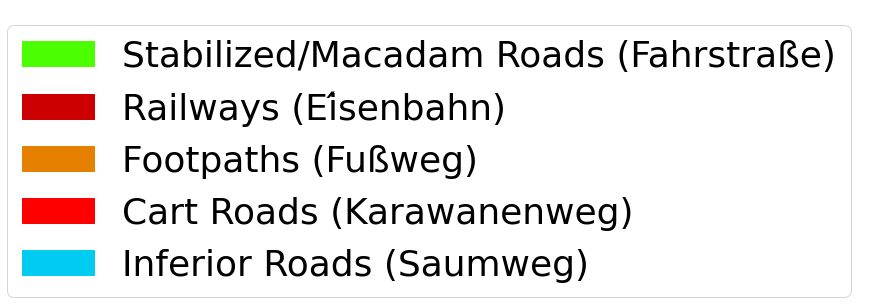

In [60]:
# Create a color palette
palette = dict(zip(labels, clrs))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
# Create legend
params = {'font.size': 36}
matplotlib.rcParams.update(params)

plt.legend(handles=handles)
# Get current axes object and turn off axis
plt.gca().set_axis_off()
plt.savefig(os.path.join(viz_dir,'LEGEND.png'), pad_inches = 0, transparent=False, bbox_inches='tight')
plt.show()

In [2]:
import numpy as np

In [3]:
F1 = [0.58494453, 0.51084298, 0.55573352, 0.57194202, 0.51975535]
Prec = [0.50699633, 0.42357872, 0.47470608, 0.49331049 , 0.43727488]
Rec = [0.69121554, 0.64339255, 0.6701153, 0.68039381, 0.64058495]
IOU = [0.41337216, 0.34304172,0.384786 , 0.40050336, 0.35112801]

F1 = np.asarray(F1)
Prec = np.asarray(Prec)
Rec = np.asarray(Rec)
IOU = np.asarray(IOU)

In [ ]:
array([[0.58494453, 0.50699633, 0.69121554, 0.41337216],
       [0.51084298, 0.42357872, 0.64339255, 0.34304172],
       [0.55573352, 0.47470608, 0.6701153 , 0.384786  ],
       [0.57194202, 0.49331049, 0.68039381, 0.40050336],
       [0.51975535, 0.43727488, 0.64058495, 0.35112801]])

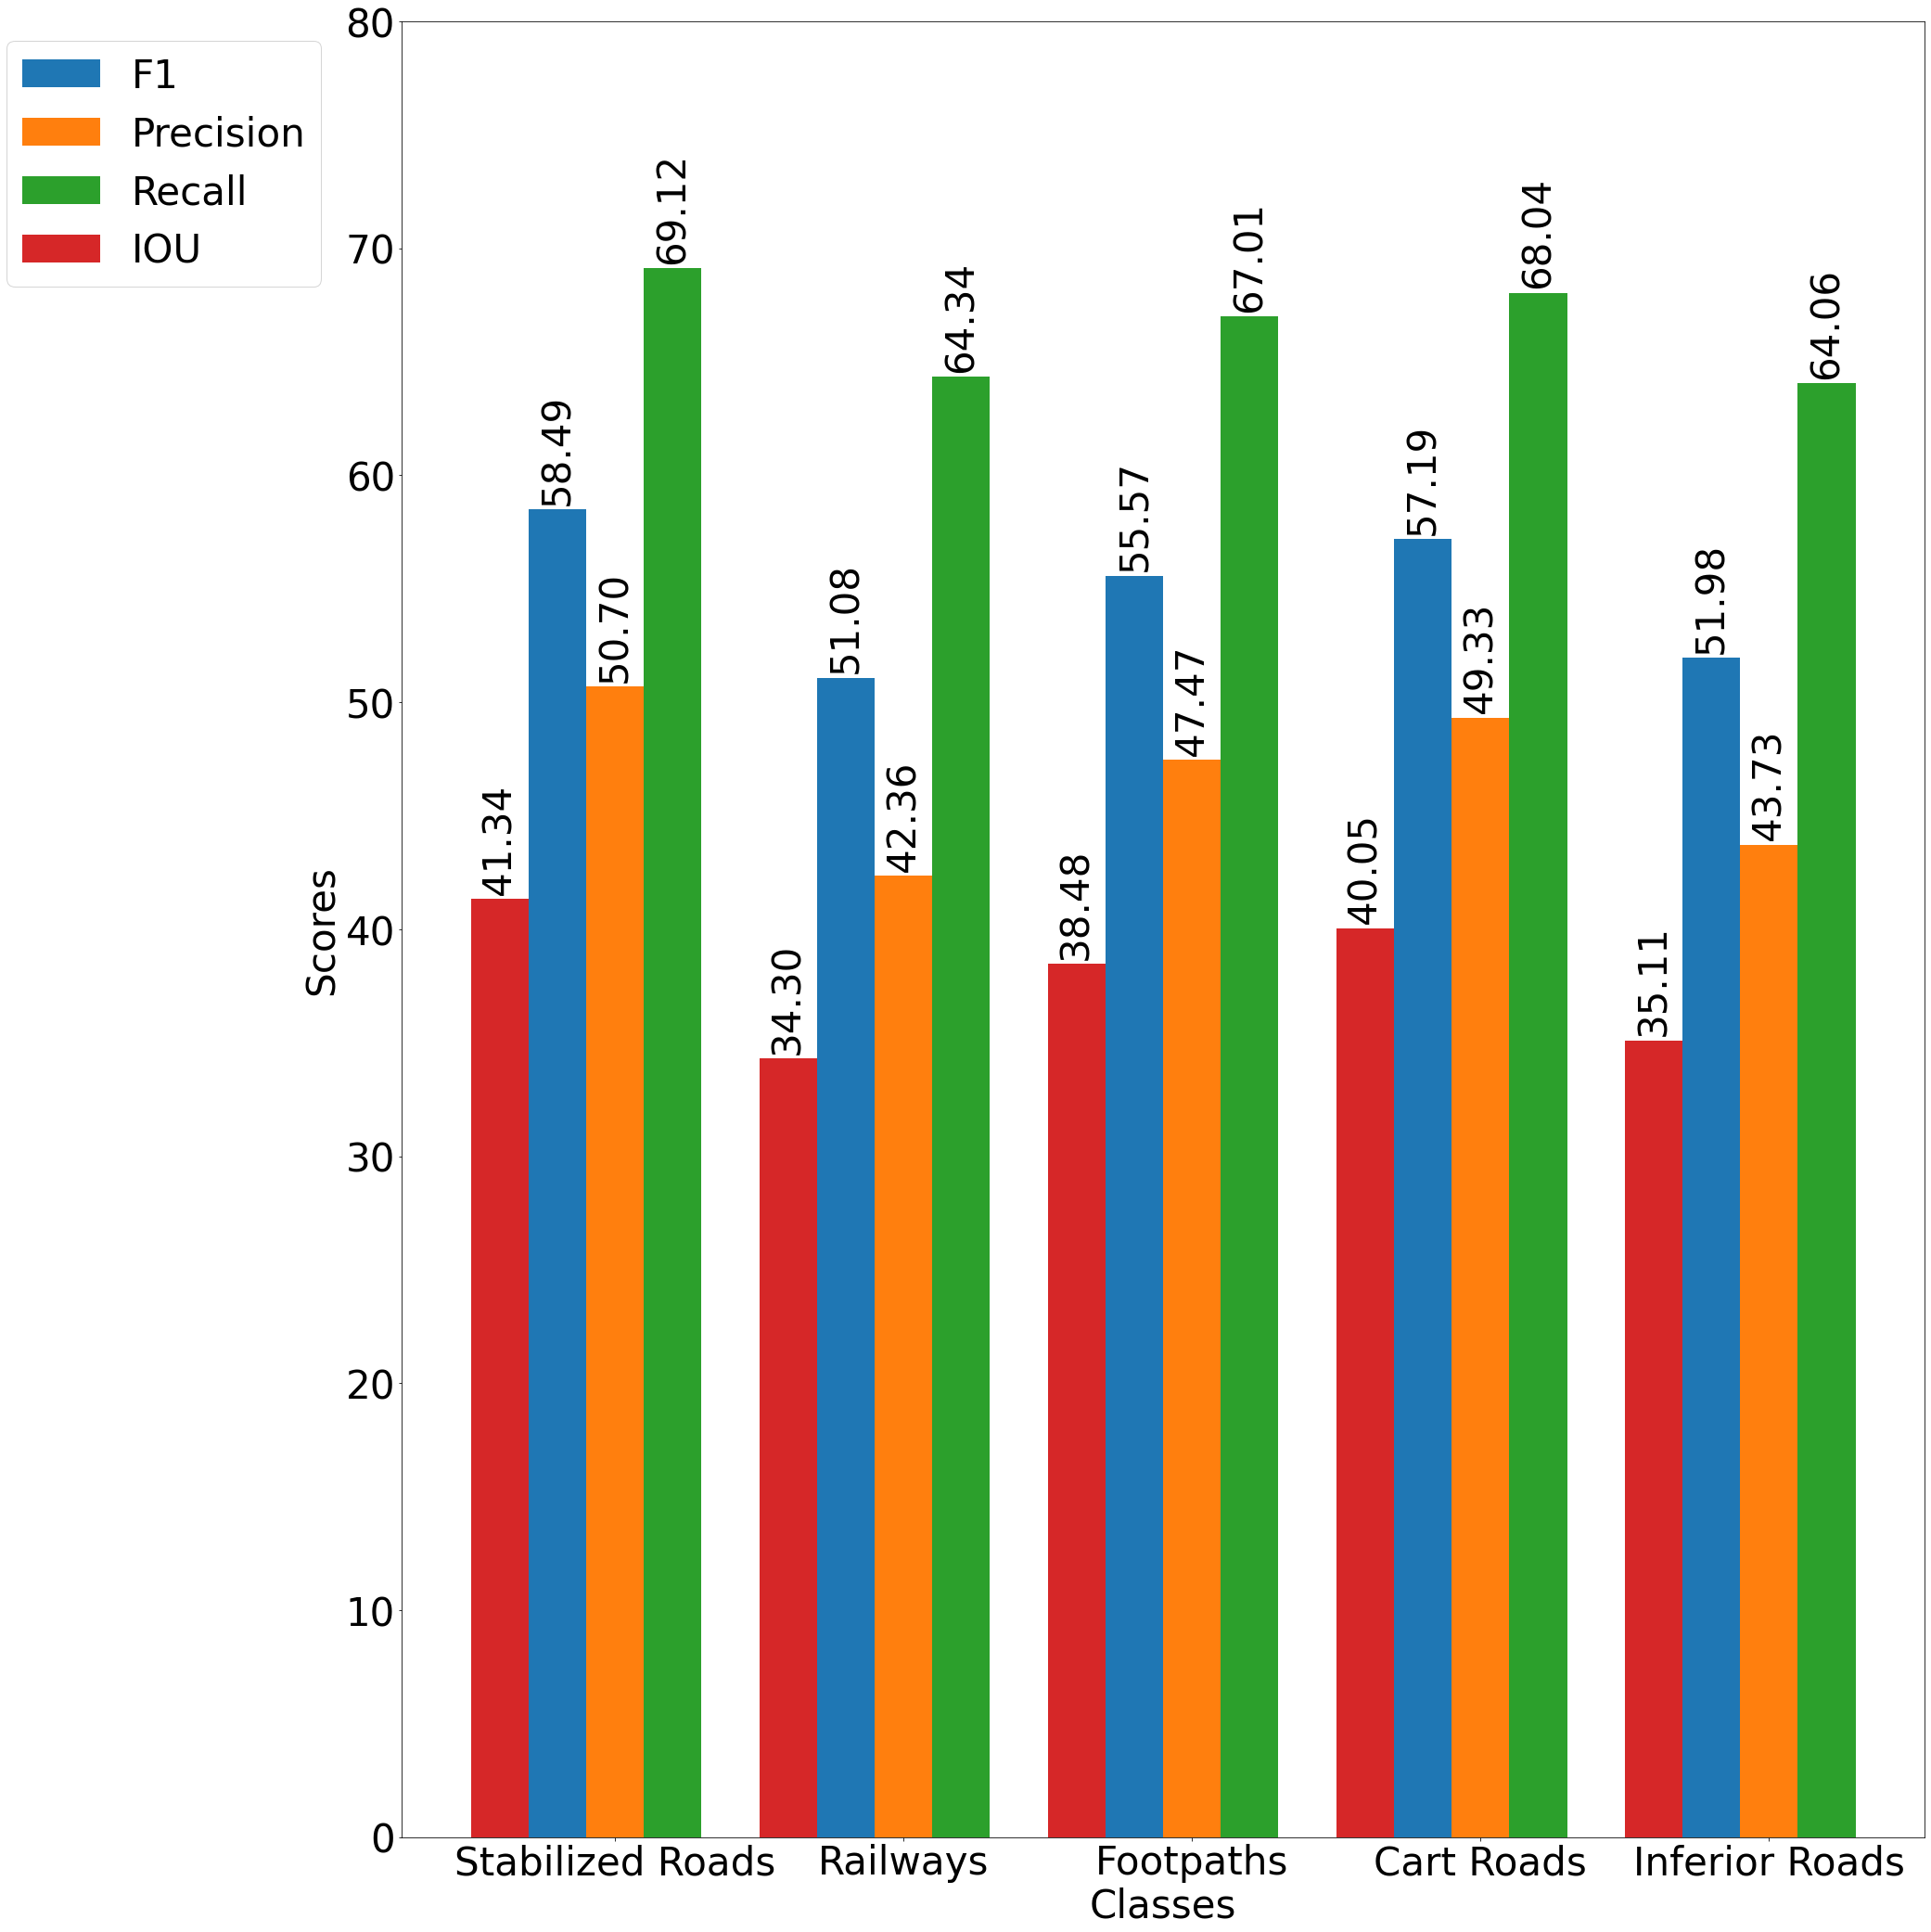

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ing_Class_names

F1_ = F1 * 100
Prec_ = Prec * 100
Recall_ = Rec * 100
IOU_ = IOU * 100

params = {'font.size': 42,
              'xtick.labelsize':42,
              'ytick.labelsize':42}
matplotlib.rcParams.update(params)

x = np.arange(len(labels))  # the label locations
width = 0.20 # the width of the bars

fig, ax = plt.subplots(figsize=(30, 30))
rects1 = ax.bar(x - width, F1_, width, label='F1')
rects2 = ax.bar(x, Prec_, width, label='Precision')
rects3 = ax.bar(x + width, Recall_, width, label='Recall')
rects4 = ax.bar(x - (2 * width), IOU_, width, label='IOU')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_title('F1 Score Comparison')
ax.set_ylabel('Scores')
ax.set_xlabel('Classes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")

ax.legend(loc='best', bbox_to_anchor=(-0.04, 0.5, 0., 0.5))
#ax.set_yticks(np.arange(60,10,20))

ax.set_ylim([0,80])

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if height == 0:
            continue
        else:
            ax.annotate('{:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', rotation = 90)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
plt.savefig(r'C:\Users\cagat\Desktop\F1_score.png', pad_inches = 0, transparent=False, bbox_inches='tight')

fig.tight_layout()

plt.show()

## geo-export

In [63]:
#eğer bu line çalışmışsa koşturma bitmiştir.

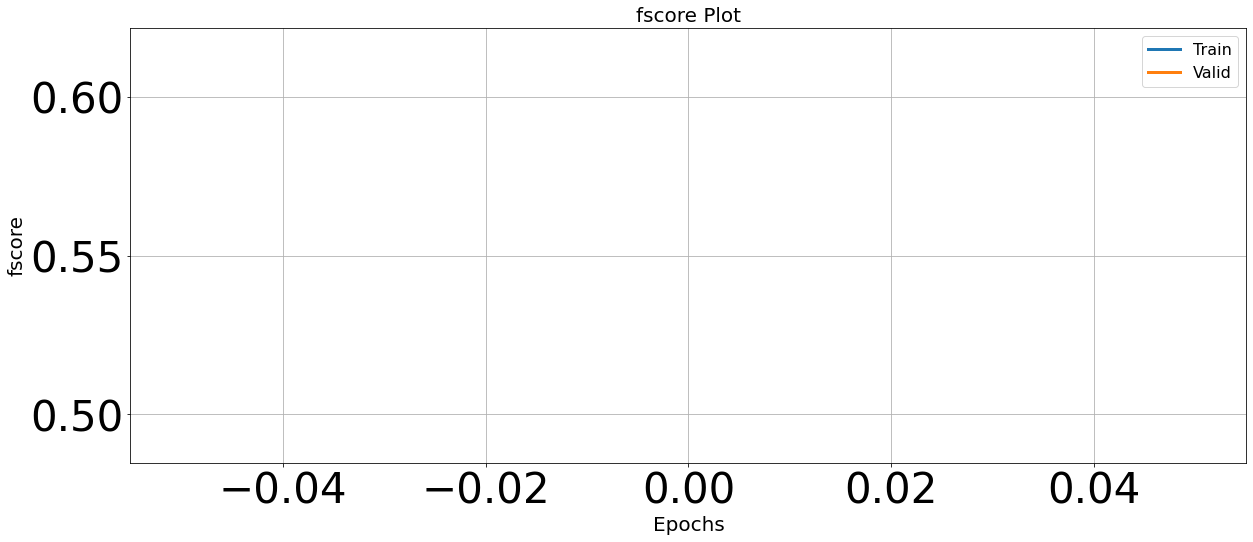

In [69]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.fscore.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.fscore.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('fscore', fontsize=20)
plt.title('fscore Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('fscore_score_plot.png')
plt.show()

In [70]:
train_logs_df.T

,0
dice_loss,0.385050
fscore,0.615477
precision,0.543505
recall,0.711675


In [79]:
train_logs_list[0]

{'dice_loss': 0.3850501411876016,
 'fscore': 0.6154766802793947,
 'precision': 0.5435045569345808,
 'recall': 0.7116748267442992}

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_list_1 =  [0.4006,
0.4863,
0.5097,
0.5246,
0.5362,
0.5463,
0.5537,
0.5733,
0.5844,
0.5906,
0.5926,
0.5944,
0.5963,
0.5949,
0.5959
                 
]
valid_list_1 = [
0.4618,
0.4694,
0.4849,
0.5017,
0.464,
0.4877,
0.4882,
0.5024,
0.4951,
0.4929,
0.5,
0.4881,
0.5002,
0.4924,
0.5031]
list(np.float_(train_list_1))
list(np.float_(valid_list_1))

[0.4618,
 0.4694,
 0.4849,
 0.5017,
 0.464,
 0.4877,
 0.4882,
 0.5024,
 0.4951,
 0.4929,
 0.5,
 0.4881,
 0.5002,
 0.4924,
 0.5031]

In [4]:
a2_train_list_1 =  [0.3933,
0.4726,
0.4958,
0.51,
0.5213,
0.5444,
0.55,
0.5552,
0.5603,
0.5636,
0.5657,
0.5685,
0.5704,
0.5731,
0.5734]
a2_valid_list_1 = [
0.4425,
0.4509,
0.456,
0.4668,
0.4631,
0.4638,
0.4613,
0.4611,
0.4579,
0.4566,
0.4589,
0.4574,
0.454,
0.4569,
0.4499]
list(np.float_(a2_train_list_1))
list(np.float_(a2_valid_list_1))

[0.4425,
 0.4509,
 0.456,
 0.4668,
 0.4631,
 0.4638,
 0.4613,
 0.4611,
 0.4579,
 0.4566,
 0.4589,
 0.4574,
 0.454,
 0.4569,
 0.4499]

In [5]:
a2_train_logs_df = pd.DataFrame(a2_train_list_1)
a2_valid_logs_df = pd.DataFrame(a2_valid_list_1)
a2_train_logs_df.columns =['fscore']
a2_valid_logs_df.columns =['fscore']

In [6]:
train_logs_df = pd.DataFrame(train_list_1)
valid_logs_df = pd.DataFrame(valid_list_1)

In [7]:
train_logs_df.columns =['fscore']
valid_logs_df.columns =['fscore']

In [15]:
train_logs_df

,fscore
0,0.4006
1,0.4863
2,0.5097
3,0.5246
4,0.5362
5,0.5463
6,0.5537
7,0.5733
8,0.5844
9,0.5906


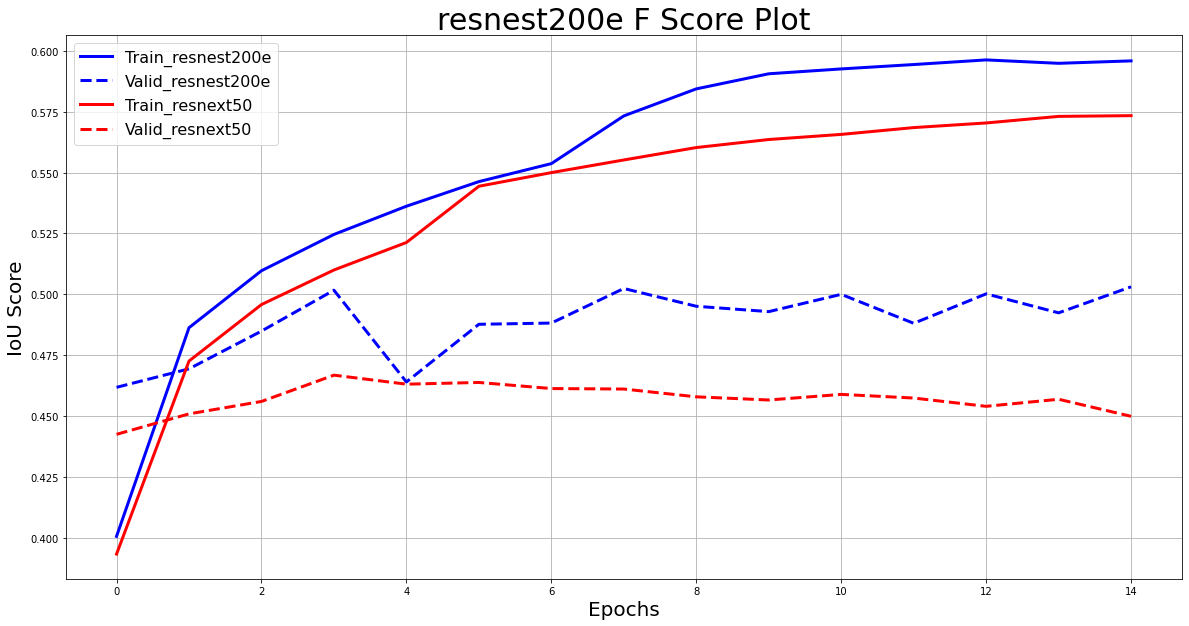

In [22]:
plt.figure(figsize=(20,10))
plt.plot(train_logs_df.index.tolist(), train_logs_df.fscore.tolist(), lw=3, label = 'Train_resnest200e',color='blue')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.fscore.tolist(), lw=3, label = 'Valid_resnest200e',color='blue',linestyle='--')
plt.plot(a2_train_logs_df.index.tolist(), a2_train_logs_df.fscore.tolist(), lw=3, label = 'Train_resnext50',color='red')
plt.plot(a2_valid_logs_df.index.tolist(), a2_valid_logs_df.fscore.tolist(), lw=3, label = 'Valid_resnext50',color='red',linestyle='--')

plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('resnest200e F Score Plot', fontsize=30)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()